In [21]:
db = pd.read_csv('dataset.csv')

After cleaning:
Sample             0
SOURCE            51
SITE               0
MARBLE GROUP       0
SELECT          1841
MGS                5
d18O               0
d13C               0
dtype: int64

Predicted class: Eph2 

Top Three Probabilities:
------------------------
Eph2 : 43.87%
Pro : 14.7%
MarathiL : 14.57%


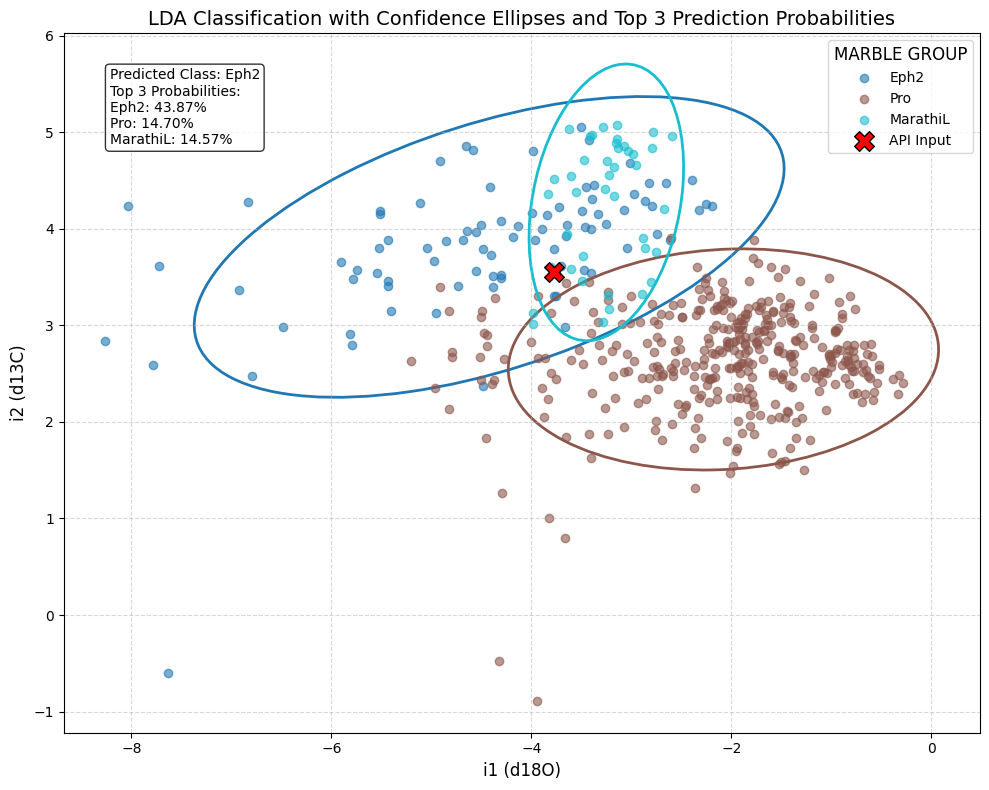

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.impute import SimpleImputer  # Only needed if imputing

# ---------------------------------------------
# Replace this section with your actual data loading
# For example:
# db = pd.read_csv('your_data.csv')
# ---------------------------------------------
# Example DataFrame (replace with your actual data)
# ---------------------------------------------

# 1. Handling Missing Values

# Option 1: Remove rows with NaN in 'd18O', 'd13C', or 'MARBLE GROUP'
db_clean = db.dropna(subset=['d18O', 'd13C', 'MARBLE GROUP'])

# Option 2: Impute missing values (Uncomment to use)
# imputer = SimpleImputer(strategy='mean')  # You can choose 'median' or 'most_frequent'
# features_to_impute = ['d18O', 'd13C']
# db[features_to_impute] = imputer.fit_transform(db[features_to_impute])
# db_clean = db.dropna(subset=['MARBLE GROUP'])  # Ensure target variable has no NaN

# Verify that there are no NaNs in the relevant columns
print("After cleaning:")
print(db_clean.isnull().sum())

# 2. Define the confidence ellipse function
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    facecolor : str
        The face color of the ellipse.
    **kwargs
        Additional keyword arguments passed to Ellipse.

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

    # Eigenvalues and eigenvectors for the covariance matrix
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Scale the ellipse to the desired number of standard deviations
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    # Calculate the transformation
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# 3. Prepare the Data for LDA

# Define your test input
i1, i2 = -3.77,3.55  # Replace these with your actual test input values
test_values = [[i1, i2]]

# Get unique classes
filtered_classes = db_clean["MARBLE GROUP"].unique()

# Prepare feature matrix X and target vector y
X = np.column_stack((db_clean["d18O"], db_clean["d13C"]))
y = db_clean["MARBLE GROUP"].values

# 4. Initialize and Fit the LDA Model
clf = LinearDiscriminantAnalysis()

try:
    clf.fit(X, y)
except ValueError as e:
    print(f"Error during LDA fitting: {e}")
    # Additional error handling can be implemented here
    # For example, further data cleaning or imputation
    exit(1)

# 5. Make Predictions
predicted_class = clf.predict(test_values)[0]
probabilities = clf.predict_proba(test_values)[0]

# Identify the top three probabilities
top_n = 3
top_indices = np.argsort(probabilities)[::-1][:top_n]
top_classes = clf.classes_[top_indices]
top_probabilities = probabilities[top_indices]

# Print predicted class and top three probabilities
print("\nPredicted class:", predicted_class, "\n")
print("Top Three Probabilities:")
print("------------------------")
for cls, prob in zip(top_classes, top_probabilities):
    print(f"{cls} : {round(prob * 100, 2)}%")

# 6. Filter the Dataset to Only Include Top Three Classes
db_top3 = db_clean[db_clean["MARBLE GROUP"].isin(top_classes)]

# 7. Start Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Assign colors to top three classes using 'tab10' colormap
colors = plt.get_cmap('tab10', len(top_classes))

# Scaling factor for the confidence ellipse (e.g., 95% confidence interval)
# For a 95% confidence interval in 2D, n_std ≈ sqrt(5.991)
n_std = np.sqrt(4.605)  # Currently 90% confidence  # Adjust based on desired confidence level

for idx, cls in enumerate(top_classes):
    subset = db_top3[db_top3["MARBLE GROUP"] == cls]
    x = subset['d18O']
    y = subset['d13C']

    # Scatter plot for the current class
    ax.scatter(x, y, alpha=0.6, label=cls, color=colors(idx))

    # Add confidence ellipse for the current class
    confidence_ellipse(x, y, ax, n_std=n_std, edgecolor=colors(idx), linewidth=2)

# Plot the API input point
ax.scatter([i1], [i2], color='red', edgecolors="k", marker='X', s=200, label='API Input')

# Set labels and title
ax.set_xlabel('i1 (d18O)', fontsize=12)
ax.set_ylabel('i2 (d13C)', fontsize=12)
ax.set_title('LDA Classification with Confidence Ellipses and Top 3 Prediction Probabilities', fontsize=14)

# Add legend
ax.legend(title='MARBLE GROUP', fontsize=10, title_fontsize=12)

# Add text box with predicted class and top three probabilities
# Corrected: Multiply probabilities by 100 to convert to percentages
prob_text = "\n".join([f"{cls}: {prob * 100:.2f}%" for cls, prob in zip(top_classes, top_probabilities)])
annotation_text = f"Predicted Class: {predicted_class}\nTop 3 Probabilities:\n{prob_text}"

# Add the text box to the plot
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.05, 0.95, annotation_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Enhance grid for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()
